In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import plotly.express as px 
import pickle 
sys.path.insert(1, "../src/utils/")
from agent import Environment
from Q_learning import QLearningTrainer
sys.path.insert(1, "plotly_graph/")
from functions4tuto import rocket_simulation, plot_rocket_altitude, plot_reward_rocket_monoagent
JOSN_file = "rocket_tuto_2.json"

# <span style="color:orange">Input file</span>

In the previous tutorial we defined our environment and designed a reward function. The system is a rocket that falling from a starting point and the goal is to reach a target with a minimum speed and maximize fuel.
Variable's names, their initial values and boundaries limit are defined into a JSON file (or can be given directly into a dictionary)

## <span style="color:orange">Variables</span>

Variables can be categorize into 3 classes:
* `states_variables` : variable used as coordinate to describe our system
* `agent_variables` : variable use as agent. Their values are changed for each iteration
* 3th category are other variables. They are not used to describe our environment but they can be usefull to monitor information or to compute intermediate value. 
  There is no key for this kind of variable. Consider them as variables present into `initial_values` field and that are not `states_variables` and `agent_variables`

You can access to the name of state and agent variables, with the attibute `states_variables` and `agent_variables`.

    "states_variables" : ["pos_y", "acceleration_y", "speed_y"],
    "agent_variables" : ["booster"]

## <span style="color:orange">Initial system</span>

After to name `states_variables` and `agent_variables`, next step is to define initial state.
It will be use as environment coordinates at the beginning of each episode. Initially, it comprises 
the values of state_variables, followed by agent_variables, and finally other variables that are 
not used for the system's coordinates.

    "initial_values" : {
      "pos_y" : [175.0],
      "speed_y": [0.0],
      "acceleration_y": [0.0],
      "weight_rocket" : [305],
      "booster" : [0.0],
      "m_fuel" : [300],
      ...
      "ratio_fuel" : [1.0],
      "dt" : [3],
      "time" : [0],
      "acceleration_limit_y" : [10],
      "speed_limit_y" : [5]
      }

**NB:** Because we do not modify rocket's angle, we will not show ```pos_x, speed_x and acceleration_x (you can see all variable by calling env.json["initial_values"])```

## <span style="color:orange">Limit</span>

Q-learning algorithms model events as a Markov process. Therefore, it is necessary to discretize our environment space. 
We define lower and upper bounds, as well as the number of divisions we want to use to discretize the variable space.

    "limit" : {
      "pos_y" : [0.0, 200.0, 41],
      "speed_y": [-30.0, 30.0, 31],
      "acceleration_y": [-20.0, 20.0, 21],
      "weight_rocket" : [0.0, 305, 62],
      "booster" : [0.0, 2.0, 3],
      "m_fuel" : [0.0, 400, 801]
    }


## <span style="color:orange">Agents's actions</span>
    "n_action" : {
      "booster": {"0" : 0.0, "1" : 1.0, "2" : 2.0}
    }

After defining the variables and their initial values, we proceed to define actions that apply to the agent variables. In this example, we have 1 agent that can take 3 actions:

For the booster:
  * "0": Booster is off.
  * "1": Booster is turned on to half of its power.
  * "2": Booster is turned on to its full power.

## <span style="color:orange">Actions to take</span>

    "action_to_take" : {
      "booster": {"$booster$" : "$action}
    }

Actions change the agent variables by modifying their values based on the action taken, which are retrieved from the n_action dictionary. You can change default delimiter during the initilisation:

`agent = Environment(json_file, delimiter = "Char_you_want")`

## <span style="color:orange">System's evolution and reward</span>

Last fields are how variables evolve after agents's action and how reward are computed.
Only variables present in field inital value are stored. Other variables present are just temporary and are lost after each iteration.
Reward values are stored into a dictionnary, the keys are agent variable's name.
Timestep value (dt) is 3, to let the system evolve enough without the need to have an high resolution in state variable's space.

### <span style="color:orange">Equation variables</span>
    "equations_variables": {
        "$F$" : "600",
        "$y_0$" : "$pos_y$",
        "$Vy_0$" : "$speed_y$",
        "$m_fuel$" : "$m_fuel$ - $booster$ *5 -np.ceil( np.abs($alpha$) ) *5",
        "$weight_rocket$" : "$weight_dry_rocket$ + $m_fuel$",
        "$acceleration_y$" : "($F$/(5+$weight_rocket$) * np.cos($angle$)) * $booster$ - $G$",
        "$speed_y$" : "($F$/(5+$weight_rocket$) * np.cos($angle$)) * $booster$ * $dt$ - $G$ * $dt$ + $Vy_0$",
        "$pos_x$": "(0.5 * $F$/(5+$weight_rocket$) * np.sin($angle$)) * $booster$ * $dt$**2 + $Vx_0$ * $dt$ + $x_0$",
        "$pos_y$": "(0.5 * $F$/(5+$weight_rocket$) * np.cos($angle$)) * $booster$ * $dt$**2 - $G$ * $dt$**2 + $Vy_0$ * $dt$ + $y_0$",
        "$futur_pos_y$" : "$pos_y$ + 3 * $speed_y$",
        "y_lower_limit" : "0",
        "y_upper_limit" : "200",
        "$upper_boundary$": "-np.exp(0) + np.exp(np.min([ np.min(-$futur_pos_y$ + y_upper_limit), 0]))",
        "$lower_boundary$": "-np.exp(0) + np.exp(np.min([ np.min($futur_pos_y$ -y_lower_limit), 0]))"
    },

### <span style="color:orange">Reward</span>

The reward indicates the immediate benefit or cost associated with the action.
The scalar feedback signal that the environment sends to the agent after it takes an action are defined into this dictionnary.

    "equations_rewards": {
      "$booster$" : "2*(-distance_y_reward) + speed_y_reward + 0.5 * ratio_fuel"
    }

## <span style="color:orange">Stop episode</span>

stop episode when goal is reach. If feature has 1 value, its feature's value must be equal.
In other hand, if feature has 2 values ([min_limit, max_limit]), criterion is bounded feature >= min_limit and feature <= max_limit

    "stop_episode" : {
      "pos_y" : [0, 5],
      "acceleration_y" : [-2,2],
      "speed_y" : [-2,2]
    }

# <span style="color:orange">A simple scenario</span>

We want to land our rocket without it crashing. In this scenario, the rocket can take three actions: turn off its booster, or turn it on at half or full power.

Let’s model our ideal scenario. We want to activate the booster when the rocket exceeds speed or acceleration limits, and on the other hand, we want to conserve fuel whenever possible.

# <span style="color:orange">Intialize environment</span>

Create an environment object with the rules defined previously. The idea is to check the new field can raise a flag to stop simulation when the criteria are reached:

* 0 <= pos_y <= 5
* -2 <= acceleration_y >= 2
* -8 <= speed_y >= 8

We will also control the speed of the rocket and its acceleration to keep as possible those parameters between this range:

* -5 >= speed_y <= 5
* -10 <= acceleration_y >= 10

In [2]:
# Create an environment object with the rules defined previously
env_ref = Environment(JOSN_file, check_model = True)
df_0 = rocket_simulation(env_ref, acceleration_y_constraint = 10, speed_y_limit = 5, timestep = 0)
plot_rocket_altitude(df_0)

check order names for states_variables

Check order names for agent_variables

check limit number of field

Check limit boundaries for initial state

Solve equations present in equations_variables field

Solve equations present in equations_rewards field

Everything is good :)
speed limit
turn on engine to increase speed
speed limit
turn on engine to increase speed
speed limit
turn on engine to increase speed
speed limit
turn on engine to increase speed
rocket is bellow the ground


The altitude plot shows that at t = 18, the rocket's altitude is 12.5, but its speed is too high. In fact, at the next timestep, the rocket's position drops to -7.4, indicating a crash.

The most important factor here is the speed: it exceeds the desired range of [-5, 5]. Unlike speed, the acceleration remains within acceptable limits.

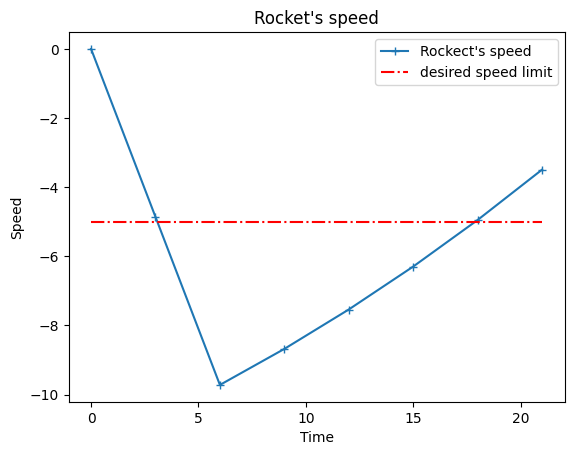

,time,pos_y,speed_y,acceleration_y,m_fuel,booster
0,0,175.000000,0.000000,0.000000,300.0,0.0
1,3,160.420000,-4.860000,-1.620000,300.0,0.0
2,6,131.260000,-9.720000,-1.620000,300.0,0.0
3,9,96.372459,-8.678361,0.347213,295.0,1.0
4,12,64.757377,-7.538361,0.380000,290.0,1.0
5,15,36.714837,-6.296666,0.413898,285.0,1.0
6,18,12.555185,-4.949769,0.448966,280.0,1.0
7,21,-7.400438,-3.493980,0.485263,275.0,1.0


In [3]:
plt.plot(df_0.time, df_0.speed_y, "+-", label="Rockect's speed")
plt.title("Rocket's speed")
plt.hlines(-5, df_0.time.to_numpy()[0], df_0.time.to_numpy()[-1], 
           color = "red", linestyles = 'dashdot', label="desired speed limit")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Speed")
plt.show()


df_0[["time", "pos_y", "speed_y", "acceleration_y", "m_fuel", "booster"]]

The speed and final position do not fully meet the success criteria.
To avoid a crash (where the speed is too high to be corrected in the next timestep), we could use the future position as an additional criterion.
The future position is calculated using the current speed and the timestep, according to the formula:

$$ futur\_positiion = pos_y + speed_y * timestep $$

# <span style="color:orange">Test different timestep for futur position</span>

In [4]:
# Try different timestep to compute furtur rocket position
for timestep in [3, 5, 10]:
    df_0["futur_position_dt+{0}".format(timestep)] = df_0["pos_y"] + df_0["speed_y"] * timestep
plot_rocket_altitude(df_0)

Let's examine the rocket's landing. As you can see, at t = 21, its position is -7.4, indicating a crash.
Ideally, we would want to prevent the crash by activating the engine before it's too late.

Using the future position projected at dt+3 or dt+5, the model predicts the crash only one timestep before it actually happens, which is too late to correct the rocket's trajectory.

On the other hand, dt+10 predicts the crash three timesteps earlier, providing enough time to react. This makes it a good candidate for implementing a static decision rule to avoid crashes.

However, depending on the rocket's speed and acceleration, using dt+10 can be problematic. If the rocket is already close to the ground and moving at low speed with low acceleration, the future position at dt+10 might incorrectly suggest a crash, causing the engine to turn on unnecessarily.

For the reason, we will use reinforcement learning to learn landing correctly.

# <span style="color:orange">Rewards</span>

Before to use reinforcement learning. Let's see how each global reward and its individual components (without their weighting coefficients) evolve. As a reminder, the reward formula for the booster is:

$$  -2 * distance\_y\_reward + speed\_y\_reward + 0.5 * ratio\_fuel $$ 

We know that in our first attempt, the rocket did not respect the speed limitation.
Let’s check whether this undesired behavior is properly detected and penalized by the reward function.

In [5]:
env_ref.reset()
df_0 = rocket_simulation(env_ref, acceleration_y_constraint = 10, speed_y_limit = 5, timestep = 0)
plot_reward_rocket_monoagent(env_ref)

speed limit
turn on engine to increase speed
speed limit
turn on engine to increase speed
speed limit
turn on engine to increase speed
speed limit
turn on engine to increase speed
rocket is bellow the ground


As we can see, when the rocket's speed is out of the desired range, the speed reward is negatively impacted, and its influence becomes stronger—even as the rocket gets closer to the ground.
Only when the rocket's speed returns to within the acceptable range does the speed penalty drop back to zero.

## <span style="color:orange">Reinforcemet learning</span>


After load our environment, next step is to create QLearningTrainer objet. It will apply Qlearning algorithm. For each states, the algorithm will apply a score base to the next iteration.

The Bellman equation is the value function use in reinforcement learning. 

$V(s,a) = V(s, a)+ \alpha * (R+\gamma * max(V(s', a')) - V(s, a))$

Where:

* $V(s, a)$ is the estimated value of state $s$ and actions $a$
* $s$ is the curent state
* $s'$ is the next state
* $a$ is action taken
* $a'$ next possible actions that maximize reward
* $R$ is the immediate reward received after transitioning
* $\gamma$ is the discount factor, which determines the importance of future rewards.
* $\alpha$ is the learning rate.

In [6]:
# Load RL object
env = Environment(JOSN_file, check_model = True)
RL = QLearningTrainer(env, 
                      num_episodes = 1000, 
                      convergence_criterion = 0.5, 
                      decay_type = "exponential",
                      decrease_prob_exp = 0.015)

check order names for states_variables

Check order names for agent_variables

check limit number of field

Check limit boundaries for initial state

Solve equations present in equations_variables field

Solve equations present in equations_rewards field

Everything is good :)


Different parameters are avaible. For the tutorial, you use default parameters. Before to lunch training. Lets discus about the input parameters.

### <span style="color:orange">Learning rate</span>


The learning rate $\alpha$ in the Bellman equation controls the weight given to the new estimate compared to the existing estimate of the state value. A smaller learning rate means that the new estimate has less influence, and the agent is more conservative in updating its value function. A larger learning rate allows the agent to adjust its estimates more rapidly based on new information

### <span style="color:orange">Discount factor (gamma)</span>

The discount factor $\gamma$, is a key hyperparameter that controls how much the agent values future rewards compared to immediate rewards. For rocket landing, $\gamma$ equal to 0.99, since we are optimizing over multiple steps to reach a safe landing.

### <span style="color:orange">Epsilon parameter</span>

Exploration-exploitation is a fundamental trade-off in reinforcement learning, where the agent needs to balance between exploring new actions and exploiting the knowledge it has gained so far.

The epsilon-greedy policy is a simple strategy that the agent uses to decide whether to explore a new action (random exploration) or exploit the current best-known action. It helps prevent the agent from getting stuck in suboptimal policies by occasionally trying new actions. The value of epsilon determines the probabilty the agent chooses a random action. A higher epsilon encourages more exploration, while a lower epsilon emphasizes exploitation of the current best-known actions.ent knowledge.

The epsilon parameter is decayed over time during training. This means that, as the agent gains more experience, it tends to rely more on exploitation and less on exploration. The idea is that, as the agent learns and becomes more confident in its estimates, it gradually reduces the rate of exploration. 

Epsilon initailization is made with the argument **exploration_prob**. It is a list with the lowest and the highest probability values. The probability will decrease with a rate given by the argument **decrease_prob_exp**. By default epsilon is modeled with a linear decay but you can change it to a exponential decay.


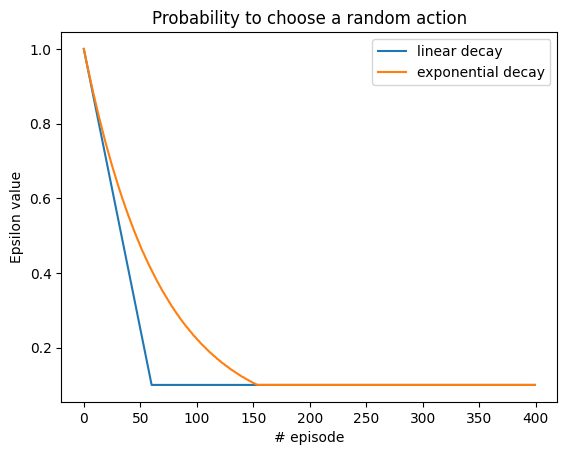

In [7]:
plt.plot(RL.get_epsilon(decay_type = 'linear')[0:400], label = "linear decay")
plt.plot(RL.get_epsilon(decay_type = 'exponential')[0:400], label = "exponential decay")
plt.title("Probability to choose a random action")
plt.legend()
plt.xlabel("# episode")
plt.ylabel("Epsilon value")
plt.show()

### <span style="color:orange">num_episodes, run_limit and convergence_criterion</span>

The last three options are hyperparameters that impact computation time:
* ``num_episodes``: The maximum number of training episodes.
* ``run_limit``: The maximum number of iterations allowed within a single episode before it is forcefully stopped.
* ``convergence_criterion``: The threshold used to determine convergence, based on the difference in Q-values between two iterations.


Before launching the training, it's important to understand that the Q-learning algorithm operates in a discretized space.
The spacing between bins can significantly impact convergence. If a discretized bin groups together too many different underlying states, the Q-table may become unstable, making it difficult for the algorithm to converge.

Let's examine how our space is discretized using ``RL.env.json["limit"]``.
The agent variable (booster) has 3 bins, while the state variables "pos_y", "acceleration_y", "speed_y", and "weight_rocket" have 41, 31, 21, and 62 bins, respectively.

This results in a Q-table with:
Our Q table is composed of $$ 3 * 41 *31 *21 *62 = 4 964 526\  states $$

Does that mean our system will visit every possible state?
Of course not. Remember, the Q-learning algorithm starts with a random exploration (a random walk), but over time, the agent’s exploration becomes guided by what it has already experienced.
As a result, some states may never be visited if the agent never finds a path leading to them or if they are not useful for improving the policy.

### <span style="color:orange">Training</span>

Training with our parameters should take between 8 and 10 minutes. You can also load a pre-trained RL object (trained ouput are stored in ``saved_model/output_train_monoagent.txt``). If you want to generate the model from scratch, start training with the command: ``RL.q_learning()``

In [ ]:
with open('saved_model/RL_monoagent.pkl', 'rb') as f:
    RL = pickle.load(f)

In [ ]:
# To start training remove comment
# RL.q_learning()
# #save model
# with open('saved_model/RL_monoagent.pkl', 'wb') as f:  # open a text file
#     pickle.dump(RL, f)

Episode 1/1000
exploration_prob : 1.000
No action possible. Stop episode at 2th iterations
Save last state even is out of bound
Q table still growths
Loss : -33.561087450218324
end while loop iteration :  2
Episode 2/1000
exploration_prob : 0.985
No action possible. Stop episode at 17th iterations
Save last state even is out of bound
Q table still growths
Loss : -144.30129991058595
end while loop iteration :  17
Episode 3/1000
exploration_prob : 0.970
No action possible. Stop episode at 6th iterations
Save last state even is out of bound
Q table still growths
Loss : -36.29296367960765
end while loop iteration :  6
Episode 4/1000
exploration_prob : 0.956
No action possible. Stop episode at 4th iterations
Save last state even is out of bound
Q table still growths
Loss : -67.34329956202285
end while loop iteration :  4
Episode 5/1000
exploration_prob : 0.942
No action possible. Stop episode at 10th iterations
Save last state even is out of bound
Q table still growths
Loss : -70.7600145437

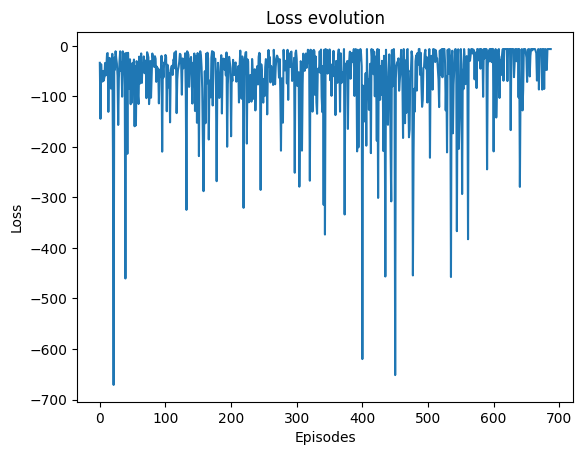

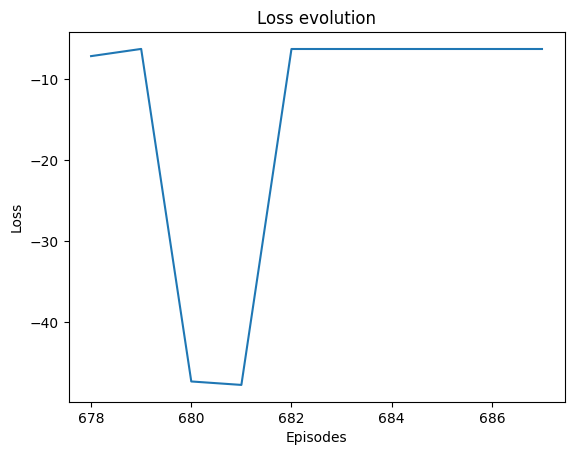

In [10]:
RL.plot_convergence() 
RL.plot_convergence(start = len(RL.loss_episodes) -10) #loss for the last 10 iterations

If you loaded the pre-trained model, you'll see that training stopped at episode 677. For the last five iterations the difference between $Qtable_N - Qtable_{N-1}$ remained bellow the convergence threshold (convergence_criterion = 0.5), indicating that the learning process had stabilized.

Let’s find out how many states we actually explored.
To do this, we replace Q-table values equal to 0 with np.nan.
(Except for goal-reaching states in our setup, a value of 0 typically means the state was never explored.)

In [11]:
states_explored = np.sum(RL.q_table.copy().replace(0, np.nan).count())

print("Number of states explored {0}.\
 Only {1:.3f}% states have been visited".format(
    states_explored,
    states_explored/4964526 *100))

Number of states explored 4562. Only 0.092% states have been visited


# <span style="color:orange">Optimal trajectory</span>

Let’s see how the rocket evolves after training.
We start by copying the Q-table using the ``q_table`` attribute, and we replace all 0 values with ``np.nan`` to better visualize learned values.

Next, we load a new environment and use its current discretized state as the starting point.
At each iteration, we follow the action suggested by the Q-table based on the environment’s current discretized state, which is updated after every step. At the end, we save all the states visited into a data frame (dt)

In [17]:
# load policy table
policy = RL.q_table.copy().replace(0, np.nan)
# load environnment
env = Environment(JOSN_file, check_model = False)
state = env.state_for_q_table()
flag_continue = True
while flag_continue:
    # control while loop
    if not policy.index.isin([str(state)]).any():
        flag_continue = False
        print("stop: no moore state")
        env.delete_last_states()
        continue
    elif env.pos_y[-1] < 0:
        print("stop: reach goal")
        env.delete_last_states()
        flag_continue = False
        continue
    action = RL.call_choose_action(state, 0)
    _, rewards, done, problem, info = env.step(action)
    state = env.state_for_q_table()

dt = pd.DataFrame(env.all_states())

stop episode because agent reach goal
stop: no moore state


# <span style="color:orange">Rocket Trajectory Comparison</span>

Let’s compare the initial rocket landing with the new one obtained using our trained policy.
As we can see, the second rocket reaches the ground more slowly than the first. Its trajectory appears more linear, and if we look at the speed profile, the reinforcement learning model keeps the speed within the desired limit of [-5, 5].

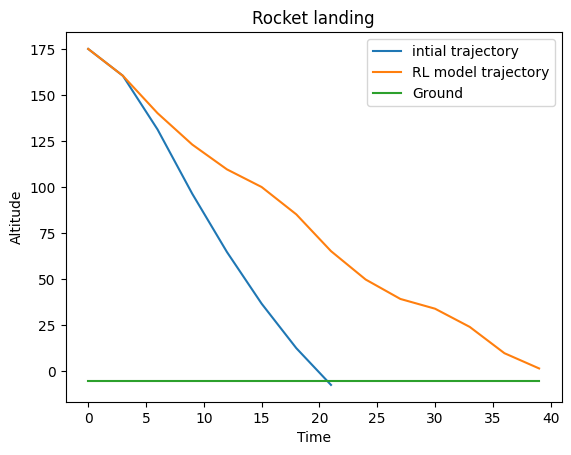

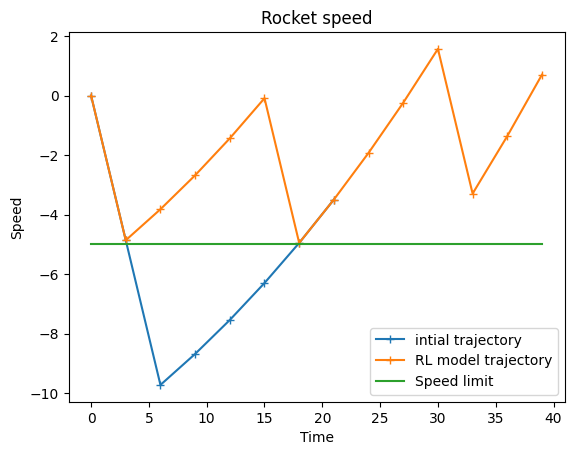

In [18]:
plt.plot(df_0[["time"]], df_0[["pos_y"]], label = "intial trajectory")
plt.plot(dt[["time"]], dt[["pos_y"]], label = "RL model trajectory")
plt.plot(dt[["time"]], np.array([-5]*len(dt[["time"]])), label = "Ground" )
plt.title("Rocket landing")
plt.xlabel("Time")
plt.ylabel("Altitude")
plt.legend()
plt.show()


plt.plot(df_0[["time"]], df_0[["speed_y"]], "+-",label = "intial trajectory")
plt.plot(dt[["time"]], dt[["speed_y"]], "+-", label = "RL model trajectory")
plt.plot(dt[["time"]], np.array([-5]*len(dt[["time"]])), label = "Speed limit" )
plt.title("Rocket speed")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.legend()
plt.show()

Even though the second rocket consumes more fuel, it successfully keeps the speed within the desired range.
As shown in the reward plots, the RL policy allows the rocket to reach its goal more smoothly, with better speed control compared to the first attempt.

In [19]:
plot_reward_rocket_monoagent(env)